In [1]:
import xarray as xr
import numpy as np 
import datetime
import pyresample 
import metpy
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import xarray

def get_XYpositions(filename, lons, lats):
    
    fh = xr.open_dataset(filename)
    x   = np.linspace(0, fh.lat.values.shape[1]-1, fh.lat.values.shape[1])
    y   = np.linspace(0, fh.lat.values.shape[0]-1, fh.lat.values.shape[0])
    xi  = np.zeros_like(fh.lon.values)
    yi  = np.zeros([fh.lon.values.shape[1], fh.lon.values.shape[0]])
    xi[:,:] = x
    yi[:,:] = y
    yi  = np.swapaxes(yi, 1, 0)

    # First I define the wet points of the field as the lon,lat values with mask_rho==1 
    sea_def = pyresample.geometry.SwathDefinition(lons= fh.lon.values[np.where(fh.mask_rho)], lats = fh.lat.values[np.where(fh.mask_rho)])

    # Second, the full grid definiton (our target domain):
    orig_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)

    # Then I fill the temperature field by the nearest neighbour approace.
    # Note that only wet points are used as input. 

    # The radius of influence sets a limit (in meters) for how far away a true value can be from the point that will be filled

    ypos = pyresample.kd_tree.resample_nearest(sea_def, yi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)

    xpos = pyresample.kd_tree.resample_nearest(sea_def, xi[np.where(fh.mask_rho)], \
                               orig_def, radius_of_influence=2400)
    return np.array([int(x) for x in xpos]), np.array([int(y) for y in ypos])


In [10]:

target_depths = [10, 15, 20, 25, 30, 40]
locations = {'Ekofisk': {'lat': 56 + 32/60, 'lon': 3 + 12/60}}
dtg = datetime.datetime.now() - datetime.timedelta(days =0 )

# Filsti peker til arkivet til Norshelf. Bytt ut storeA med storeB når logget inn på datarom B. 
# Fullt arkiv er kun tilgjengelig på storeB. 
path = '/lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/{}/{}/norshelf_qck_ZDEPTHS_an_{}T00Z.nc'
#path = '/lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc'
# Beregn X, Y posisjon for stasjoner i dictionary locations, sett opp et pandas dataframe for å lagre resultater i: 
for loc, coord in locations.items():
    df = pd.DataFrame({'SITE': [] , 'LAT': [], 'LONG': [], 'DEPTH': [], 'TIME': [] , 'PROG': [], 'CD[deg]': [], 'CV[m/s]': [] })

    locations[loc]['X'], locations[loc]['Y'] = get_XYpositions(path.format( dtg.strftime('%Y/%m'), dtg.strftime('%Y%m%d')), np.array([coord['lon']]), np.array([coord['lat']])) 
    


IndexError: Replacement index 2 out of range for positional args tuple

In [5]:
dtg_start = datetime.datetime(2024, 5,20 ) 
dtg_stop  = datetime.datetime.now()
loc = 'Ekofisk'

# Loop over dagene du vil trekke ut data for:
while dtg_start <= dtg_stop:
    # Fyll in rikig dato i filnavnet:
    workonfile = path.format( dtg_start.strftime('%Y/%m'), dtg_start.strftime('%Y%m%d'))
    
    print('Working on {}, {}'.format(dtg_start, workonfile))
    # Sjekk om filen eksisterer (arkivet kan ha hull)
    if os.path.exists(workonfile):
        # Åpne fil for lesing. Filen lukkes automatisk når man går ut av "with ... as ds" blokken. 
        try:
            with xr.open_dataset(workonfile) as ds:
                # Velg kun strøm
                ds = ds.get(['u_eastward', 'v_northward'])
                # Velg dyp:
                ds = ds.sel(depth = slice(min(target_depths), max(target_depths)))
                # Velg Ekofisk punkt, basert på X, Y funnet i forrige celle. 
                tmp = ds.isel(xi_rho = locations[loc]['X'], eta_rho = locations[loc]['Y'])

                #Behandle hvert dyp:
                for d in target_depths:

                    tmp0 = tmp.sel(depth = d)

                    # Regne om vind til speed/retning:
                    cspd = np.squeeze(metpy.calc.wind_speed(tmp0.u_eastward.values*metpy.units.units('m/s') , tmp0.v_northward*metpy.units.units('m/s')))
                    cdir = np.squeeze(metpy.calc.wind_direction(tmp0.u_eastward.values*metpy.units.units('m/s') , tmp0.v_northward*metpy.units.units('m/s'), convention = 'to'))

                    # Legg til informasjonen i pandas dataframe:
                    df = pd.concat([df, pd.DataFrame({'SITE': [loc]*len(cspd) , 'LAT': [np.round(coord['lat'],3)] *len(cspd), 'LONG': [np.round(coord['lon'],3)] *len(cspd), 'DEPTH': [d]*len(cspd), 'TIME': [dtg_start.strftime('%Y-%m-%dT00:00:00Z')]*len(cspd) , 'PROG': [t.replace('T', ' ') + ' UTC' for t in np.datetime_as_string(tmp0.time, unit = 's')], 'CD[deg]':np.round(cdir,1), 'CV[m/s]': np.round(cspd,2)  })])

                # Skriv resultater til csv -fil:
                df.to_csv('{}.csv'.format(loc), header = 'SITE,LAT,LONG,TIME,PROG,CD[deg],CV[m/s]', mode = 'a', index = False)
        except:
            pass
    # Oppdater dtg_start slik at ved neste iterasjon leses data for neste dag
    dtg_start += datetime.timedelta(days = 1)

Working on 2024-05-20 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-21 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-22 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-23 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-24 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-25 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-26 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPTHS_fc_latest.nc
Working on 2024-05-27 00:00:00, /lustre/storeB/project/fou/hi/oper/norshelf/archive/forecast/norshelf_qck_ZDEPT

In [6]:
# Du kan se innholdet i dataframe slik: 
df.head(20) # hvor tallet indikerer hvor mange linjer du skal se på:


,SITE,LAT,LONG,DEPTH,TIME,PROG,CD[deg],CV[m/s]
0,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 00:00:00 UTC,96.699997,0.12
1,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 01:00:00 UTC,153.199997,0.13
2,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 02:00:00 UTC,182.699997,0.19
3,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 03:00:00 UTC,197.000000,0.23
4,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 04:00:00 UTC,208.000000,0.21
5,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 05:00:00 UTC,221.399994,0.15
6,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 06:00:00 UTC,262.600006,0.05
7,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 07:00:00 UTC,9.800000,0.09
8,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 08:00:00 UTC,30.500000,0.18
9,Ekofisk,56.533,3.2,10.0,2024-05-20T00:00:00Z,2024-06-25 09:00:00 UTC,39.200001,0.24


/tmp/ipykernel_1932572/1409085181.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.xticks(tmp.PROG[0::24*15]);


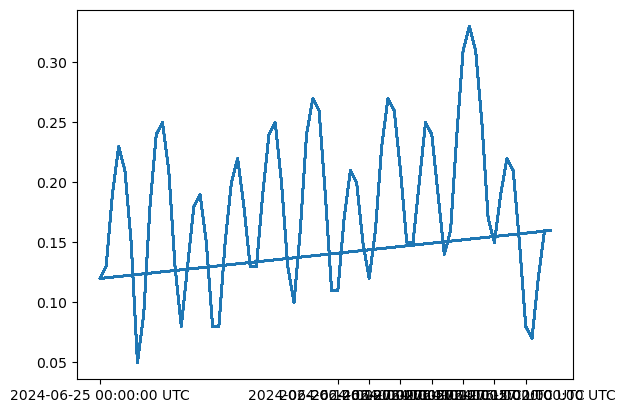

In [7]:
tmp = df[df.DEPTH == 10]
plt.plot(tmp.PROG, tmp['CV[m/s]'])
plt.xticks(tmp.PROG[0::24*15]);

/tmp/ipykernel_1932572/3305602936.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.xticks(tmp.PROG[0::24*15]);


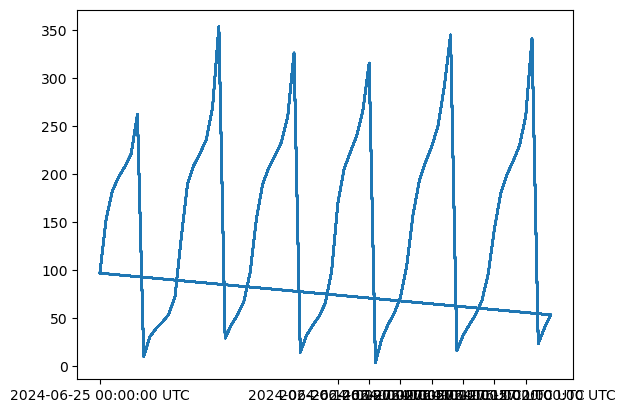

In [8]:
tmp = df[df.DEPTH == 10]
plt.plot(tmp.PROG, tmp['CD[deg]'])
plt.xticks(tmp.PROG[0::24*15]);

In [9]:
dtg_start = datetime.datetime(2024, 5,20 ) 
dtg_stop  = datetime.datetime.now()
loc = 'Ekofisk'
filelist = []
# Loop over dagene du vil trekke ut data for:
while dtg_start <= dtg_stop:
    # Fyll in rikig dato i filnavnet:
    workonfile = path.format( dtg_start.strftime('%Y/%m'), dtg_start.strftime('%Y%m%d'))
    filelist.extend(glob.glob(workonfile))
    
    dtg_start += datetime.timedelta(days = 1)
    
with xr.open_mfdataset(filelist, data_vars = ['u_eastward','v_northward']) as ds:
    # Velg kun strøm
    ds = ds.get(['u_eastward','v_northward'])
    # Velg dyp:
    ds = ds.sel(depth = slice(min(target_depths), max(target_depths)))
    # Velg Ekofisk punkt, basert på X, Y funnet i forrige celle. 
    tmp = ds.isel(xi_rho = locations[loc]['X'], eta_rho = locations[loc]['Y'])

    #Behandle hvert dyp:
    for d in target_depths:

        tmp0 = tmp.sel(depth = d)

        # Regne om vind til speed/retning:
        cspd = np.squeeze(metpy.calc.wind_speed(tmp0.u_eastward.values.squeeze()*metpy.units.units('m/s') , tmp0.v_northward.values.squeeze()*metpy.units.units('m/s')))
        cdir = np.squeeze(metpy.calc.wind_direction(tmp0.u_eastward.values.squeeze()*metpy.units.units('m/s') , tmp0.v_northward.values.squeeze()*metpy.units.units('m/s'), convention = 'to'))

        # Legg til informasjonen i pandas dataframe:
        df = pd.concat([df, pd.DataFrame({'SITE': [loc]*len(cspd) , 'LAT': [np.round(coord['lat'],3)] *len(cspd), 'LONG': [np.round(coord['lon'],3)] *len(cspd), 'DEPTH': [d]*len(cspd), 'TIME': [dtg_start.strftime('%Y-%m-%dT00:00:00Z')]*len(cspd) , 'PROG': [t.replace('T', ' ') + ' UTC' for t in np.datetime_as_string(tmp0.time, unit = 's')], 'CD[deg]':np.round(cdir,1), 'CV[m/s]': np.round(cspd,2)  })])

    # Skriv resultater til csv -fil:
    df.to_csv('{}.csv'.format(loc), header = 'SITE,LAT,LONG,TIME,PROG,CD[deg],CV[m/s]', mode = 'a', index = False)




ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [ ]:
df.head()

In [ ]:
xr.open_mfdataset?

In [ ]:
tmp0.u_eastward.values.squeeze()